In [1]:

from huggingface_hub import login
login("insert_your_token")
import torch
print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

!pip install bitsandbytes>=0.39.0
!pip install --upgrade accelerate transformers datasets peft trl


GPU available: True
GPU name: Tesla T4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Label mappings: {'credit_card': 0, 'credit_reporting': 1, 'debt_collection': 2, 'mortgages_and_loans': 3, 'retail_banking': 4}
Sampled dataset size: 8121
Train size: 6496
Validation size: 812
Test size: 813


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 673,541 || all params: 110,159,626 || trainable%: 0.6114


Map:   0%|          | 0/6496 [00:00<?, ? examples/s]

Map:   0%|          | 0/812 [00:00<?, ? examples/s]

Map:   0%|          | 0/813 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-12791b294743>:154: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.993000,0.607143,0.489857,0.428129,0.607143
2,1.162800,0.888039,0.642857,0.562312,0.547983,0.642857
3,0.936500,0.834255,0.689655,0.650035,0.648028,0.689655
4,0.859400,0.776936,0.720443,0.686575,0.694929,0.720443
5,0.801900,0.758871,0.722906,0.688783,0.701954,0.722906


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Results: {'eval_loss': 0.7588711380958557, 'eval_accuracy': 0.7229064039408867, 'eval_f1': 0.6887825973485203, 'eval_precision': 0.7019539333732212, 'eval_recall': 0.7229064039408867, 'eval_runtime': 3.6316, 'eval_samples_per_second': 223.592, 'eval_steps_per_second': 14.043, 'epoch': 5.0}
Test Accuracy: 0.7319
Test F1 Score: 0.6892


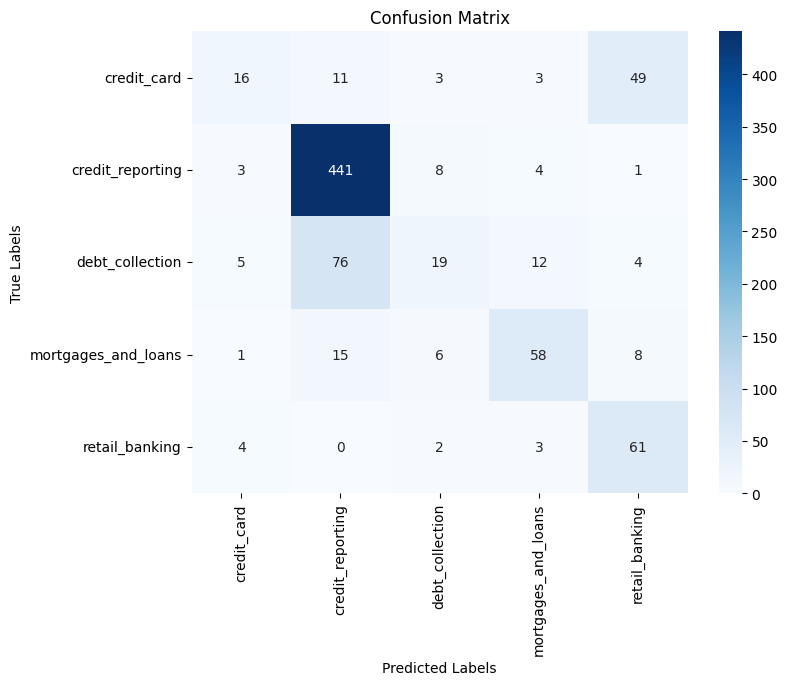

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("complaints_processed.csv")
df = df.drop(columns=["Unnamed: 0"])  # Drop unnecessary columns
df.head()
# Encode labels
label_encoder = LabelEncoder()
df["product_label"] = label_encoder.fit_transform(df["product"])
label_mappings = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label mappings: {label_mappings}")

# Sample 5% of the data
sampled_df = df.sample(frac=0.05, random_state=42)  # Randomly sample 5% of the data
print(f"Sampled dataset size: {len(sampled_df)}")

# Stratified split into train (80%) and temp (20%)
train_df, temp_df = train_test_split(
    sampled_df,
    test_size=0.2,
    stratify=sampled_df["product_label"],
    random_state=42
)

# Stratified split temp into validation (50%) and test (50%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["product_label"],
    random_state=42
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Prepare data for Hugging Face datasets
train_texts = train_df["narrative"].tolist()
val_texts = val_df["narrative"].tolist()
test_texts = test_df["narrative"].tolist()

train_labels = train_df["product_label"].tolist()
val_labels = val_df["product_label"].tolist()
test_labels = test_df["product_label"].tolist()

train_dataset = Dataset.from_dict({"text": train_texts, "labels": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "labels": val_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "labels": test_labels})

# Load tokenizer and BERT model with BNB config



# Load tokenizer and BERT model with BNB config
model_id = "bert-base-uncased"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,
    num_labels=5,
    torch_dtype=torch.float32,  # or bfloat16
)
model.to(device)

# # Load the model
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_id,
#     num_labels=len(label_mappings),
#     quantization_config=bnb_config,
#     torch_dtype=torch.float32,  # Use mixed precision
#     low_cpu_mem_usage=True,    # Reduce memory usage during loading
# )

# # Move the model to GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)



# Apply LoRA configuration
lora_config = LoraConfig(
    r=4,
    lora_alpha=32,
    target_modules=["query", "key", "value", "dense"],  # LoRA target modules
    task_type=TaskType.SEQ_CLS,
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Tokenize datasets
def tokenize_data(data):
    return tokenizer(
        data["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_val = val_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

# Define compute_metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,  # Use mixed precision
    report_to="none",  # Disable wandb logging
    optim="paged_adamw_8bit",  # Optimized optimizer for quantized training
)
# training_args.gradient_checkpointing = True

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Fine-tune the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("Validation Results:", results)

# Predict on the test set
raw_preds, labels, _ = trainer.predict(tokenized_test)
predictions = torch.argmax(torch.tensor(raw_preds), dim=-1).numpy()

# Compute accuracy
accuracy = accuracy_score(labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")




# Compute F1 score
f1 = f1_score(labels, predictions, average="weighted")
print(f"Test F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mappings.keys(), yticklabels=label_mappings.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


First few rows of the dataset:
            product                                          narrative
0       credit_card  purchase order day shipping amount receive pro...
1       credit_card  forwarded message date tue subject please inve...
2    retail_banking  forwarded message cc sent friday pdt subject f...
3  credit_reporting  payment history missing credit report speciali...
4  credit_reporting  payment history missing credit report made mis...
Label mappings: {'credit_card': 0, 'credit_reporting': 1, 'debt_collection': 2, 'mortgages_and_loans': 3, 'retail_banking': 4}
Sampled dataset size: 8121
Train size: 6496
Validation size: 812
Test size: 813
pad_token_id was not set. Using eos_token_id: 128009
Model pad_token_id set to: 128009


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model pad_token_id set to: 128009
Using device: cuda
trainable params: 600,064 || all params: 1,236,424,704 || trainable%: 0.0485


Map:   0%|          | 0/6496 [00:00<?, ? examples/s]

Map:   0%|          | 0/812 [00:00<?, ? examples/s]

Map:   0%|          | 0/813 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-10-ed8789cc5698>:277: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.392900,0.963791,0.636700,0.581794,0.584311,0.636700
2,0.851300,0.838721,0.678571,0.643073,0.659773,0.678571
3,0.791300,0.730035,0.732759,0.722940,0.726008,0.732759
4,0.683600,0.707692,0.740148,0.730512,0.731393,0.740148
5,0.673000,0.692793,0.743842,0.732910,0.732235,0.743842


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Validation Results: {'eval_loss': 0.6927928328514099, 'eval_accuracy': 0.7438423645320197, 'eval_f1': 0.7329100665082611, 'eval_precision': 0.7322352137501436, 'eval_recall': 0.7438423645320197, 'eval_runtime': 21.1374, 'eval_samples_per_second': 38.415, 'eval_steps_per_second': 4.826, 'epoch': 5.0}
Test Accuracy: 0.7368
Test F1 Score: 0.7258


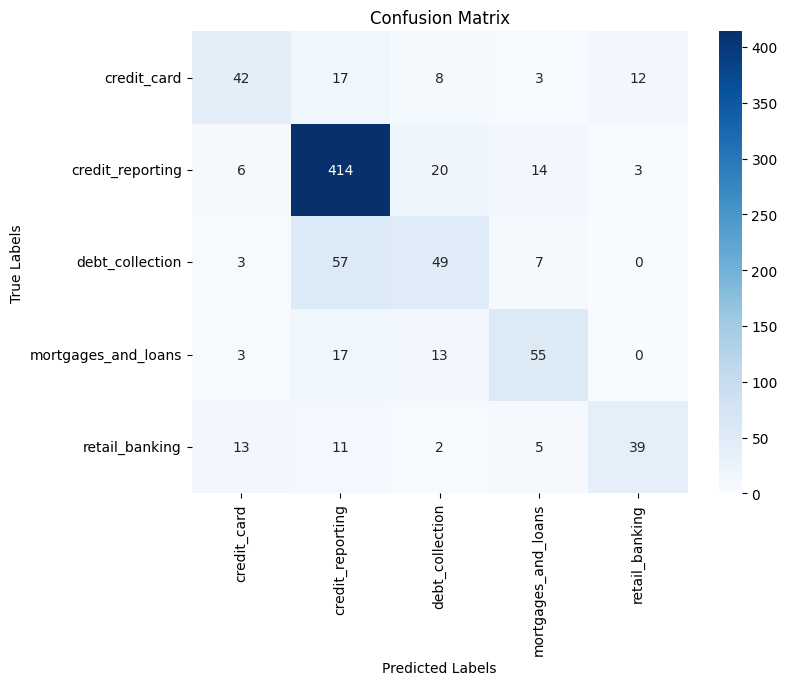

7392

In [ ]:
# ============================
# 1. Install Required Packages
# ============================

# It's good practice to install packages within the script when using environments like Google Colab.
# However, ensure that you're not reinstalling packages unnecessarily, which can slow down your setup.
import torch
import gc
import sys
import os

def clear_memory():
    """
    Clears GPU and CPU memory to prevent memory leaks and CUDA errors.
    """
    # Clear CUDA cache
    if torch.cuda.is_available():
        print("Clearing CUDA cache...")
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.ipc_collect()  # Collects shared memory

    # Collect garbage
    print("Collecting garbage...")
    gc.collect()

    # Delete all variables in the global scope (use with caution)
    # This is more applicable in interactive environments like Jupyter notebooks
    if 'ipykernel' in sys.modules:
        print("Deleting variables from the global namespace...")
        for name in dir():
            if not name.startswith('_'):
                del globals()[name]
        gc.collect()

    # Optional: Reset CUDA device (use only if necessary)
    # This can be useful if the CUDA device is in an unstable state
    # os.system("nvidia-smi --gpu-reset -i 0")  # Requires appropriate permissions

    print("Memory cleared successfully.\n")

!pip install bitsandbytes>=0.39.0
!pip install -U bitsandbytes
!pip install --upgrade accelerate transformers datasets peft trl

# ============================
# 2. Import Necessary Libraries
# ============================

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support
)
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import gc  # For garbage collection

# ============================
# 3. Data Preparation
# ============================

# Load dataset
df = pd.read_csv("complaints_processed.csv")
df = df.drop(columns=["Unnamed: 0"])  # Drop unnecessary columns
print("First few rows of the dataset:")
print(df.head())

# Encode labels
label_encoder = LabelEncoder()
df["product_label"] = label_encoder.fit_transform(df["product"])
label_mappings = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label mappings: {label_mappings}")

# Sample 5% of the data
sampled_df = df.sample(frac=0.05, random_state=42)  # Randomly sample 5% of the data
print(f"Sampled dataset size: {len(sampled_df)}")

# Stratified split into train (80%) and temp (20%)
train_df, temp_df = train_test_split(
    sampled_df,
    test_size=0.2,
    stratify=sampled_df["product_label"],
    random_state=42
)

# Stratified split temp into validation (50%) and test (50%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["product_label"],
    random_state=42
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Prepare data for Hugging Face datasets
train_texts = train_df["narrative"].tolist()
val_texts = val_df["narrative"].tolist()
test_texts = test_df["narrative"].tolist()

train_labels = train_df["product_label"].tolist()
val_labels = val_df["product_label"].tolist()
test_labels = test_df["product_label"].tolist()

train_dataset = Dataset.from_dict({"text": train_texts, "labels": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "labels": val_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "labels": test_labels})

# ============================
# 4. Model and Tokenizer Setup
# ============================

# Define model ID for LLaMA
model_id = "meta-llama/Llama-3.2-1B-Instruct"

# Initialize tokenizer
# Note: LLaMA models may require specifying the `use_fast` parameter or other tokenizer-specific settings.
# Additionally, LLaMA tokenizers might not have a `pad_token_id` defined by default, which is essential for padding.

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

# Check if pad_token_id is set; if not, set it to eos_token_id or another appropriate value.
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
    print(f"pad_token_id was not set. Using eos_token_id: {tokenizer.eos_token_id}")

# Define BitsAndBytesConfig
# It's generally safer to use float16 unless you have a GPU that supports bfloat16.
# Most consumer GPUs (like NVIDIA's) support float16.

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,  # Use float16 for broader GPU support
)

# Initialize model without device_map
# LLaMA models may not have a built-in sequence classification head.
# If not, AutoModelForSequenceClassification will add a classification head.

# Ensure the tokenizer has a pad_token_id
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
    print(f"pad_token_id set to eos_token_id: {tokenizer.eos_token_id}")

# Update the model's configuration to use the same pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id
print(f"Model pad_token_id set to: {model.config.pad_token_id}")


model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,
    num_labels=len(label_mappings),
    torch_dtype=torch.float32,  # Use float16
    # Removed device_map='auto'
)

model.config.pad_token_id = tokenizer.pad_token_id
print(f"Model pad_token_id set to: {model.config.pad_token_id}")

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the device
model = model.to(device)

# ============================
# 5. Apply LoRA Configuration
# ============================

# Define LoRA configuration with accurate target modules for LLaMA
# LLaMA's transformer layers are typically named like "self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "mlp.fc_out"
# However, it's essential to inspect the model's architecture to confirm.

# Inspect module names to identify correct target modules
# Uncomment the following lines to print module names for debugging
# for name, module in model.named_modules():
#     print(name)

# Based on typical LLaMA architecture, target modules might be:
lora_config = LoraConfig(
    r=4,
    lora_alpha=32,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "mlp.fc_out"
    ],
    task_type=TaskType.SEQ_CLS,
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# ============================
# 6. Tokenization
# ============================

# Define tokenization function
def tokenize_data(data):
    return tokenizer(
        data["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_val = val_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

# ============================
# 7. Define Metrics
# ============================

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted"
    )
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# ============================
# 8. Training Arguments
# ============================

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Reduced from 16 to manage GPU memory
    per_device_eval_batch_size=8,   # Reduced from 16 to manage GPU memory
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,  # Use mixed precision
    report_to="none",  # Disable wandb logging
    optim="paged_adamw_8bit",  # Optimized optimizer for quantized training
)

# Optional: Enable gradient checkpointing to further reduce memory usage
training_args.gradient_checkpointing = True

# ============================
# 9. Initialize Trainer
# ============================

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# ============================
# 10. Fine-Tune the Model
# ============================

# Start training
trainer.train()

# ============================
# 11. Evaluate the Model
# ============================

# Evaluate on validation set
results = trainer.evaluate()
print("Validation Results:", results)

# ============================
# 12. Test Predictions
# ============================

# Predict on the test set
raw_preds, labels, _ = trainer.predict(tokenized_test)
predictions = torch.argmax(torch.tensor(raw_preds), dim=-1).numpy()

# Compute accuracy
accuracy = accuracy_score(labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute F1 score
f1 = f1_score(labels, predictions, average="weighted")
print(f"Test F1 Score: {f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_mappings.keys(),
    yticklabels=label_mappings.keys()
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# ============================
# 13. Cleanup
# ============================

# Clear GPU cache and perform garbage collection
torch.cuda.empty_cache()
gc.collect()


First few rows of the dataset:
            product                                          narrative
0       credit_card  purchase order day shipping amount receive pro...
1       credit_card  forwarded message date tue subject please inve...
2    retail_banking  forwarded message cc sent friday pdt subject f...
3  credit_reporting  payment history missing credit report speciali...
4  credit_reporting  payment history missing credit report made mis...
Label mappings: {'credit_card': 0, 'credit_reporting': 1, 'debt_collection': 2, 'mortgages_and_loans': 3, 'retail_banking': 4}
Sampled dataset size: 8121
Train size: 6496, Validation size: 812, Test size: 813
Using device: cuda
pad_token_id set to eos_token_id: 128001


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.1-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model pad_token_id set to: 128001


Map:   0%|          | 0/813 [00:00<?, ? examples/s]

<ipython-input-18-0108eb4b3491>:183: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(test_labels)
<ipython-input-18-0108eb4b3491>:220: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels).to(device)  # Ensure test_labels are a PyTorch tensor


Test Accuracy: 0.1476
Test F1 Score: 0.1331
Test Precision: 0.3210
Test Recall: 0.1476


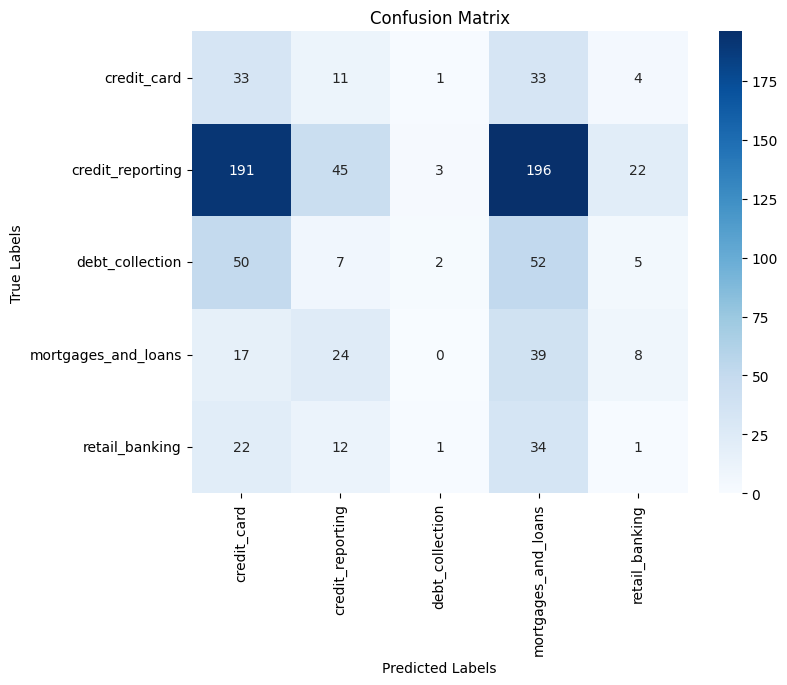

In [18]:

# ============================
# 1. Install Required Packages
# ============================

# It's good practice to install packages within the script when using environments like Google Colab.
# However, ensure that you're not reinstalling packages unnecessarily, which can slow down your setup.
import torch
import gc
import sys
import os

def clear_memory():
    """
    Clears GPU and CPU memory to prevent memory leaks and CUDA errors.
    """
    # Clear CUDA cache
    if torch.cuda.is_available():
        print("Clearing CUDA cache...")
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.ipc_collect()  # Collects shared memory

    # Collect garbage
    print("Collecting garbage...")
    gc.collect()

    # Delete all variables in the global scope (use with caution)
    # This is more applicable in interactive environments like Jupyter notebooks
    if 'ipykernel' in sys.modules:
        print("Deleting variables from the global namespace...")
        for name in dir():
            if not name.startswith('_'):
                del globals()[name]
        gc.collect()

    # Optional: Reset CUDA device (use only if necessary)
    # This can be useful if the CUDA device is in an unstable state
    # os.system("nvidia-smi --gpu-reset -i 0")  # Requires appropriate permissions

    print("Memory cleared successfully.\n")


!pip install bitsandbytes>=0.39.0
!pip install -U bitsandbytes
!pip install --upgrade accelerate transformers datasets peft trl

from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import gc

# Clear GPU memory
torch.cuda.empty_cache()

# Run garbage collection to clean up unused memory
gc.collect()



# ============================
# 1. Data Preparation
# ============================

# Load dataset
df = pd.read_csv("complaints_processed.csv")
df = df.drop(columns=["Unnamed: 0"])  # Drop unnecessary columns
print("First few rows of the dataset:")
print(df.head())

# Encode labels
label_encoder = LabelEncoder()
df["product_label"] = label_encoder.fit_transform(df["product"])
label_mappings = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label mappings: {label_mappings}")

# Sample 5% of the data
sampled_df = df.sample(frac=0.05, random_state=42)  # Randomly sample 5% of the data
print(f"Sampled dataset size: {len(sampled_df)}")

# Stratified split into train (80%) and temp (20%)
train_df, temp_df = train_test_split(
    sampled_df,
    test_size=0.2,
    stratify=sampled_df["product_label"],
    random_state=42
)

# Stratified split temp into validation (50%) and test (50%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["product_label"],
    random_state=42
)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Prepare data for Hugging Face datasets
test_texts = test_df["narrative"].tolist()
test_labels = test_df["product_label"].tolist()
test_labels = torch.tensor(test_labels).to(device)  # Ensure test_labels are a PyTorch tensor

test_dataset = Dataset.from_dict({"text": test_texts, "labels": test_labels})

# ============================
# 2. Model and Tokenizer Setup
# ============================

# Define model ID for LLaMA
model_id = "meta-llama/Llama-3.1-8B"



# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

# Ensure tokenizer has a `pad_token_id`
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
    print(f"pad_token_id set to eos_token_id: {tokenizer.eos_token_id}")

# Define BitsAndBytesConfig for quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16  # Use float16 for GPU compatibility
)

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,
    num_labels=len(label_mappings),
    torch_dtype=torch.float16,
)
model.gradient_checkpointing_enable()

# Set the model's pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id
print(f"Model pad_token_id set to: {model.config.pad_token_id}")

# Move the model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")
model = model.to(device)

# ============================
# 3. Tokenization
# ============================

from torch.utils.data import DataLoader, TensorDataset

# ============================
# 3. Tokenization
# ============================

# Define tokenization function
def tokenize_data(data):
    return tokenizer(
        data["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )

# Tokenize test dataset
tokenized_test = test_dataset.map(tokenize_data, batched=True)

# Convert to PyTorch Datasets
input_ids = torch.tensor([x["input_ids"] for x in tokenized_test])
attention_mask = torch.tensor([x["attention_mask"] for x in tokenized_test])
labels = torch.tensor(test_labels)

# Create a DataLoader with a batch size
batch_size = 8  # You can adjust this based on your available GPU memory
test_dataset = TensorDataset(input_ids, attention_mask, labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# ============================
# 4. Make Predictions with Batching
# ============================

model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids_batch, attention_mask_batch, _ = [x.to(device) for x in batch]

        # Forward pass
        outputs = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
        logits = outputs.logits

        # Get predictions for this batch
        batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        predictions.append(batch_predictions)

# Concatenate all batch predictions
predictions = np.concatenate(predictions, axis=0)

# ============================
# 5. Evaluate Metrics
# ============================

# Compute metrics



test_labels = torch.tensor(test_labels).to(device)  # Ensure test_labels are a PyTorch tensor

# accuracy = accuracy_score(test_labels.cpu().numpy(), predictions)
# f1 = f1_score(test_labels.cpu().numpy(), predictions, average="weighted")
# precision, recall, _, _ = precision_recall_fscore_support(test_labels.cpu().numpy(), predictions, average="weighted")

# print(f"Test Accuracy: {accuracy:.4f}")
# print(f"Test F1 Score: {f1:.4f}")
# print(f"Test Precision: {precision:.4f}")
# print(f"Test Recall: {recall:.4f}")
# cm = confusion_matrix(labels, predictions)
# plt.figure(figsize=(8, 6))
# sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=label_mappings.keys(),
#     yticklabels=label_mappings.keys()
# )
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix")
# plt.show()



# Convert test_labels to CPU NumPy array
labels_cpu = labels.cpu().numpy()           # Move labels to CPU
predictions_np = predictions                # Already a NumPy array if you've concatenated

# Compute metrics
accuracy = accuracy_score(labels_cpu, predictions_np)
f1 = f1_score(labels_cpu, predictions_np, average="weighted")
precision, recall, _, _ = precision_recall_fscore_support(labels_cpu, predictions_np, average="weighted")

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Compute confusion matrix
cm = confusion_matrix(labels_cpu, predictions_np)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_mappings.keys(),
    yticklabels=label_mappings.keys()
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
